In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

###### [[import libraries]]

In [2]:
# Import data analysis libraries
import numpy as np
import pandas as pd

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tell seaborn to be pretty
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.2)

# Import string manipulation and analysis libraries
import re
from fuzzywuzzy import fuzz

##### [[convenience functions for visualizations]]

In [3]:
# Quick fix for labeling count data
# Borrowed from: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

def show_values_on_bars(axs, h_v="v", space=0.4, ypad=0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, (_y + ypad), value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y + ypad, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
    
# Keep my countplots looking how I like them
def CountPlot(variable, title, xlabel, ylabel):

    plt.figure(figsize=(14,5))
    g = sns.countplot(y=derived[variable], 
                      order=derived[variable].value_counts().index)

    plt.title(title, fontsize=36, y=1.04)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    
    g.set_xticks(np.arange(0,(derived[variable].value_counts().max()+1)))

    show_values_on_bars(g, "h", 0.05, ypad=-0.19)

    sns.despine()

    plt.show()

# Data Standardization

First, I read in and concatenated the strings. The printed strings below represent my raw inputs after concatenation.

In [4]:
# Import the raw csv
raw = pd.read_csv('./raw data/raw_separated_strings.csv')

# Set the index
raw.index = raw['Source']

# Drop the index from the columns
raw = raw[raw.columns[1:]]

# Replace NaNs with spaces
raw = raw.replace(np.nan, ' ', regex=True)

# Label the index columns appropriately for my purposes
raw.columns = [str((int(s) -1)) for s in raw.columns] # start at index zero
raw.columns = ['idx_' + s for s in raw.columns] # label the columns as index columns

# Concatenate the strings
raw['string_raw'] = [''.join([str(s)[0] for s in list(raw.loc[idx])]).strip() for idx in raw.index]
raw['string_raw'] = [s.strip() for s in raw['string_raw']]

# Preview the data
for source in raw.index:
    print('{}\n{}\n'.format(source, raw.loc[source]['string_raw']))

Cloud
4I3Al aKmHl 0*8)8% AkMbL @k^cG8% E0J B8^6Dk)3>

ABC1
4I3Al n*p)pBl# E0J N8O8AgDk)3>

ABC2
4I3Al dQ8Bl jKiEdK0# @0QjGh)8 n*p)pAl# E0J JkIePk#3>

ABC3
4I3Al p)pBl n*p)pFlC QjGdK0#.

ABC4
4I3Al kFiKbL3 2)qJgD )qJgDk)3>

ABC5
4I3Al kFiHl# KfIkBl# !gPk#3< @0QjGdK0#.

ABC6
4I3Al p)pBl n*p)pFlC QjGdK0# @0QjGh)8 kFiKjL3 2)qJgDk)3>

ABC7
4I3Al kFiKbL3 qJgDk)3 2)qJgH0* Dq*aL JkIePk)3>

ABC8
kBiKaL3 4I3Bl n*o*aGdK3#.

ABC9
kBiKaL3 dQ8Bl n*jKiEdK3#.

ABC10
kBiKaL3 4I3Bl kO0*2Dk#3>

NTN1
4I3Al kFiBl# @0EjGdK0#.

NTN2
dQ8Al aF8FlC !8Dk#1>

NTN3
dQ8Al n*aF8FlC !8Dk#1>

NTE1
4I3Al kFiBl# #mGoOdK1# @oIjGrI @0QjGh)8 dQ8Al 4I3*5 n*aF8Pk#1>

NTE2
4I3Al kFiBl# #mGoOdK1# @oIjGrI

NTE3
dQ8Al 4I3*5 n*aF8Dk#1 2)qJgH0* $i#aL N8B8&dK0#.

NTW1
kFiAl# Dq*bL N8Af*fLc 2)qJgPk)3>

NTW2
4I3Al kFiAl# @0QjGh)8 dQ8Al n*aF8Pk#1>

NTO1
aL KfIbL3 n*o*aGdK3!.

NTO2
aL N8B8&bL N8O8AgDk#1>

CR1
n*p)pAl# E0J P0PbL N8P0PfL N8P0PfLc o*aGdK3#.

CR2
n*p)pAl# E0J K8)cBl e)j qJgDk#3>

CR3
n*p)pAl# E0J Ko*bL KiIb 2Ib 2Ib#dK3#.



To go about this in a way that works for me, I will have to make the strings naive to inversions & standardize the differences in the keys that the two of you are using. I will use the conventions associated with uninverted symbols, and I will map the symbols associated with the numbers 0-8 to 0-8 even though they are likely serving another purpose in the texts. 

The printed strings below represent my data after standardization.

In [5]:
# Create a dictionary to house 
standardize_dict = {}


# Read in the key and map 
key = pd.read_csv('./raw data/key_equivalencies.csv')

for idx in key.index:
    standardize_dict[key.loc[idx]['Symbol']] = key.loc[idx]['Symbol'] # Translate Symbol to Symbol
    standardize_dict[key.loc[idx]['Inverse']] = key.loc[idx]['Symbol'] # Translate Inverse to Symbol
    standardize_dict[key.loc[idx]['Aspasia_Numeric']] = key.loc[idx]['Symbol'] # Translate Aspasia's Numeric Codes to Symbol

standardize_dict[' '] = ' ' # Empty space is equivalent to empty space. Really makes you think.


# Create a column to house the standardized strings
raw['string_generic'] = [''.join([standardize_dict[s] for s in entry]) for entry in raw['string_raw']]


# Preview the data
for source in raw.index:
    print('{}\n{}\n'.format(source, raw.loc[source]['string_generic']))

Cloud
4i3al akmhl 088085 akmbl 2k6cg85 e0j b866dk03.

ABC1
4i3al n8p0pbl3 e0j n8o8agdk03.

ABC2
4i3al dq8bl jkiedk03 20qjgh08 n8p0pal3 e0j jkiepk33.

ABC3
4i3al p0pbl n8p0pflc qjgdk03.

ABC4
4i3al kfikbl3 20qjgd 0qjgdk03.

ABC5
4i3al kfihl3 kfikbl3 1gpk33, 20qjgdk03.

ABC6
4i3al p0pbl n8p0pflc qjgdk03 20qjgh08 kfikjl3 20qjgdk03.

ABC7
4i3al kfikbl3 qjgdk03 20qjgh08 dq8al jkiepk03.

ABC8
kbikal3 4i3bl n8o8agdk33.

ABC9
kbikal3 dq8bl n8jkiedk33.

ABC10
kbikal3 4i3bl ko082dk33.

NTN1
4i3al kfibl3 20ejgdk03.

NTN2
dq8al af8flc 18dk31.

NTN3
dq8al n8af8flc 18dk31.

NTE1
4i3al kfibl3 3mgoodk13 2oijgri 20qjgh08 dq8al 4i385 n8af8pk31.

NTE2
4i3al kfibl3 3mgoodk13 2oijgri

NTE3
dq8al 4i385 n8af8dk31 20qjgh08 4i3al n8b87dk03.

NTW1
kfial3 dq8bl n8af8flc 20qjgpk03.

NTW2
4i3al kfial3 20qjgh08 dq8al n8af8pk31.

NTO1
al kfibl3 n8o8agdk31.

NTO2
al n8b87bl n8o8agdk31.

CR1
n8p0pal3 e0j p0pbl n8p0pfl n8p0pflc o8agdk33.

CR2
n8p0pal3 e0j k80cbl e0j qjgdk33.

CR3
n8p0pal3 e0j ko8bl kiib 2ib 2ib3dk33.



I'll set aside a copy of the raw ledger in case I need to come back to it sometime.

An appendix is referenced here: ___raw_strings.CSV___

In [6]:
raw.to_csv('raw_strings.csv')
print('Saved progress in the root folder as raw_strings.csv')

print('\nColumns:')
print(raw.columns)

Saved progress in the root folder as raw_strings.csv

Columns:
Index(['idx_0', 'idx_1', 'idx_2', 'idx_3', 'idx_4', 'idx_5', 'idx_6', 'idx_7',
       'idx_8', 'idx_9', 'idx_10', 'idx_11', 'idx_12', 'idx_13', 'idx_14',
       'idx_15', 'idx_16', 'idx_17', 'idx_18', 'idx_19', 'idx_20', 'idx_21',
       'idx_22', 'idx_23', 'idx_24', 'idx_25', 'idx_26', 'idx_27', 'idx_28',
       'idx_29', 'idx_30', 'idx_31', 'idx_32', 'idx_33', 'idx_34', 'idx_35',
       'idx_36', 'idx_37', 'idx_38', 'idx_39', 'idx_40', 'idx_41', 'idx_42',
       'idx_43', 'idx_44', 'idx_45', 'idx_46', 'idx_47', 'idx_48', 'idx_49',
       'idx_50', 'idx_51', 'idx_52', 'idx_53', 'idx_54', 'idx_55', 'idx_56',
       'idx_57', 'idx_58', 'idx_59', 'idx_60', 'idx_61', 'string_raw',
       'string_generic'],
      dtype='object')


In [7]:
derived = raw.copy()

# Examining Source Location

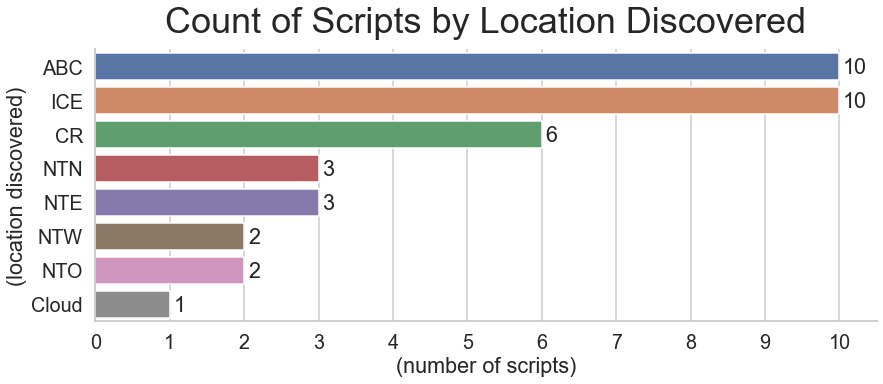

In [8]:
def BarPlot(variable, title, xlabel, ylabel):  

    plt.figure(figsize=(14,5))
    g = sns.countplot(y=derived[variable], 
                      order=derived[variable].value_counts().index)

    plt.title(title, fontsize=36, y=1.04)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
      
    g.set_xticks(np.arange(0,(derived[variable].value_counts().max()+1)))

    show_values_on_bars(g, "h", 0.05, ypad=-0.19)

    sns.despine()

    plt.show()

    
derived['location_found'] = [''.join(s for s in s if s.isalpha()) for s in derived.index]
    
CountPlot(variable='location_found', 
          title='Count of Scripts by Location Discovered', 
          xlabel='(number of scripts)',
          ylabel='(location discovered)')

##### Notes & Questions -- 
* Following Aspasia's hypothesis that the characters correspond to concepts and words rather than letters, do the locations of these various texts provide us with any insight as to the meanings of given characters? 
* Kind of a stretch, maybe. But all of the 10-table locations have strong elemental associations: ABC is a cave, so earth. The northern temple is full of lava, like, very full, so fire. The ice cave is... icy. Cloud, of course, is in the air. Does this offer us anything interesting? Maybe not!
* ABC, ICE, and NT (in the aggregate) all have ten sequences. __Are we sure there aren't four more at crossroads? We'll have to go investigate.__

## Characters

*Barely any commentary. He didn't organize the columns. The work is more hurried than nearly everything else. He clearly shifted his attention away from this nearly immediately after completing the ledger.*

*Nonetheless, the ledger exists:* ___raw_strings.CSV___ 

In [9]:
# Count characters
unique_characters = set([s for s in ''.join(list(derived['string_generic']))])

for sub in unique_characters:
    if sub == ' ':
        name = 'space'
    else:
        name = sub
    derived['count_{}'.format(name)] = [derived.loc[idx]['string_generic'].count(sub) for idx in derived.index]

In [10]:
character_counts = derived[['string_generic'] + [s for s in derived.columns if 'count' in s]]

character_counts.to_csv('character_counts.CSV')
print('Saved progress in the root folder as character_counts.CSV')

print('\nColumns:')
print(character_counts.columns)

Saved progress in the root folder as character_counts.CSV

Columns:
Index(['string_generic', 'count_h', 'count_8', 'count_.', 'count_n', 'count_6',
       'count_l', 'count_f', 'count_,', 'count_7', 'count_i', 'count_2',
       'count_1', 'count_d', 'count_e', 'count_r', 'count_g', 'count_5',
       'count_p', 'count_o', 'count_space', 'count_b', 'count_3', 'count_q',
       'count_0', 'count_m', 'count_c', 'count_k', 'count_4', 'count_a',
       'count_j'],
      dtype='object')


## Aspasia's n-grams

Aspasia's research revealed the following frequent n-grams/words. I was going to visualize my counts of them and to calculate their co-occurrences, but recent developments shifted my attention to assigning meanings. I am tying these notes together quickly so that the two of you can finish solving this. Here is a ledger where I tally them for each sequence we've found. Hopefully it will be useful to you.

An appendix is referenced here: ___n-gram_counts.CSV___

In [11]:
# Count Aspasia's ngrams for each entry
aspasia_ngrams = pd.read_csv('/Users/eve/Dropbox/My Mac (MacBook-Air.attlocal.net)/Desktop/Triangle Cipher/letter ngrams/aspasia_ngrams.csv')
aspasia_ngrams_list = [''.join([standardize_dict[s] for s in entry]) for entry in aspasia_ngrams['ngram']]

for sub in aspasia_ngrams_list:
    derived['ngramcount_{}'.format(sub)] = [derived.loc[idx]['string_generic'].count(sub) for idx in derived.index]
    
    
ngram_counts = derived[['string_generic'] + [s for s in derived.columns if 'ngram' in s]]
ngram_counts.to_csv('./n-gram_counts.CSV')
ngram_counts.head(1)

character_counts.to_csv('n-gram_counts.CSV')
print('Saved progress in the root folder as n-gram_counts.CSV')

print('\nColumns:')
print(ngram_counts.columns)

Saved progress in the root folder as n-gram_counts.CSV

Columns:
Index(['string_generic', 'ngramcount_p0p', 'ngramcount_kfi', 'ngramcount_bgkf',
       'ngramcount_n8', 'ngramcount_al', 'ngramcount_bl', 'ngramcount_4i3',
       'ngramcount_85', 'ngramcount_k33', 'ngramcount_k03', 'ngramcount_k31',
       'ngramcount_e0j', 'ngramcount_dq8', 'ngramcount_flc', 'ngramcount_20q',
       'ngramcount_agd', 'ngramcount_jgd', 'ngramcount_o8', 'ngramcount_k80c',
       'ngramcount_pb8k', 'ngramcount_1gd', 'ngramcount_h08',
       'ngramcount_af8'],
      dtype='object')


# XKXX Sequences

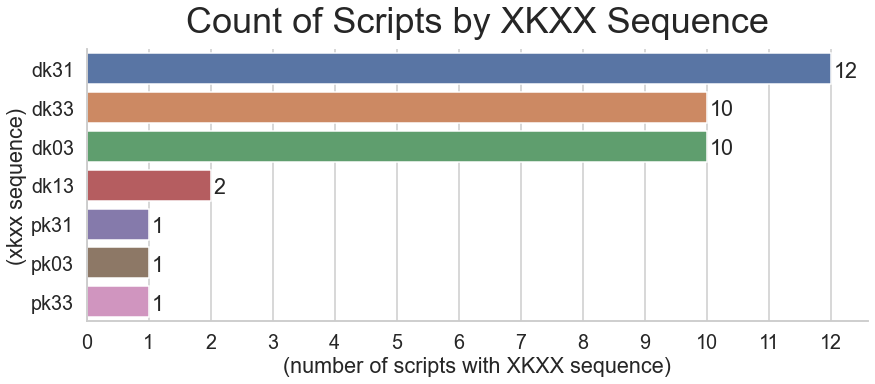

In [12]:

re_xkxx = '[dp]k.{2}' # A regex statement to grab XKXX sequences
derived['string_xkxx_extracted'] = [re.sub(re_xkxx, '', s) for s in derived['string_generic']]
derived['string_xkxx'] = [re.search(re_xkxx, s).group(0) for s in derived['string_generic']]


CountPlot(variable='string_xkxx', 
          title='Count of Scripts by XKXX Sequence', 
          xlabel='(number of scripts with XKXX sequence)',
          ylabel='(xkxx sequence)')

#### Noting that p is a wildly rare prefix in the context of xkxx sequences, I've reproduced the strings associated with it below. Note that, in the ABC string, it occurs before a comma rather than a period. What's so special about NTW1 and NTW2?

In [13]:
derived[derived['string_xkxx'].str.contains('pk')][['string_xkxx', 'string_generic']]

,string_xkxx,string_generic
Source,,
ABC5,pk33,"4i3al kfihl3 kfikbl3 1gpk33, 20qjgdk03."
NTW1,pk03,kfial3 dq8bl n8af8flc 20qjgpk03.
NTW2,pk31,4i3al kfial3 20qjgh08 dq8al n8af8pk31.


##### Notes & Questions -- 
* Only the suffixes 31, 33, 13, and 03 occur. Only the prefixes d and p occur. Why might this be?
* p is much rarer than d. Why might *this* be?
* Is there a _morphological_ relationship between d and p? What about k? What about 0-3?
* Why are XKXX sequences so consistent throughout the main scripts, but not present or necessary in Roche's work, the ice wall, or the org statue? Is it because they are a part of sentence structure? Is it because they are cipher keys of some kind (possibly indicating that Roche's work and the org statue use some kind of unmodified base alphabet)? Are they codes to activate machines? Do they aggregate into a separate message? Is it a really big coincidence?

## XKXX Fullwords
*Barely any commentary. A section with no writing. He moved on before starting.*

In [14]:
derived['string_xkxx_fullword_extracted'] = [
    ' '.join([s for s in [s for s in fullstring.split(' ')] 
     if bool(re.search(re_xkxx, s)) == False])
    for fullstring in derived['string_generic']]

derived['string_xkxx_fullword'] = [
    [s for s in [s for s in fullstring.split(' ')] 
     if bool(re.search(re_xkxx, s)) == True][0].replace('.','').replace(',','')    
    for fullstring in derived['string_generic']]

derived['string_xkxx_prefix']= [re.sub(re_xkxx,'',s) for s in derived['string_xkxx_fullword']]

# Proposed Partial Translation Based on Recent Discoveries & Aspasia’s Ideogram Hypothesis

As I was working on these analyses, one of my triangle brokers passed me a piece of information I'd been missing about the ice wall. I reflected on Aspasia's observations about language and on her hypothesis that the symbols are ideogramatic rather than phonetic. I have never met anyone so clever. So I followed her reasoning as closely as I could. Then I tried, hard, to put together all of the information that I had.

In [15]:
hints = pd.read_csv('triangle_hints.csv')
hints

hints['string_generic'] = [''.join([standardize_dict[s] for s in entry]) for entry in hints['raw_string']]
for idx in hints.index:
    print('{}: {}'.format(hints.loc[idx]['name'],hints.loc[idx]['string_generic']))
    print('{}\n'.format(hints.loc[idx]['context']))

ROCHE1: bgkfl4g
I'm sure they mean sunrise. Or… maybe they mean… the past. Things that happened long ago.

ROCHE2: bgkfl4
Take away one letter… and it's noon. Things happening right now. The present.

ORG: kfi
A statue of an org.

ICEWALL1: p0p
By the icy altars at the healer ruin south of Giayl.

ICEWALL2: n8p0p
By the icy altars at the healer ruin south of Giayl.



#### ROCHE SEQUENCES:
* Take away __g__ from ROCHE1 and move from SUNRISE/PAST (__bgkfl4g__) to NOON/PRESENT (__bgkfl4__). 
* Take away another character, likely __4__, and move from NOON/PRESENT (__bgkfl4__) to FUTURE/SUNSET (__bgkfl__).

I will follow Aspasia's assertion that the org statue means time, rather than the literal 'org'. __kf__ occurs here ahead of the tense modifications apparently offered by __4__ and __g__. Does __bg__, then, represent DAY? ETERNITY? HISTORY? EVENTS? And is the default tense in this language future? What is __l__'s role in the word?

#### ORG SEQUENCE:
Continuing to follow Aspasia's assertion that the ORG sequence __kfi__ means time, rather than the literal 'org'. The co-occurrence of __kf__ here and in the Roche sequences bolsters that theory. Orgs alter time around them -- some speed it, others slow it. Does __i__ represent CHANGE? MANIPULATION?

#### ICE WALL SEQUENCES:
I received intelligence from one of my triangle brokers suggesting that some people see the ice behind the __p0p__ sequence as a burning candle and the ice behind the __n8p0p__ sequence as an extinguished candle. Does the prefix __n8__ have the function of NEGATING the text after it? Does __p0p__ mean LIFE? FIRE? 


### Below, I attempt to translate the texts following these definitions:

In [16]:
meaning_dict = {'n8':'[NEGATE/EXTINGUISH]', 
                'p0p':'[LIFE/FLAME]', 
                'kf':'[TIME]', 
                'bg':'[DAY/ALL]',
                'i':'[ALTER]',
                '4':'[FUTURE]',
                'l':'[PRESENT]',
                'a':'[PERSON(S)]',
                'b':'[OCCUR]',
                'g':'[IS]'}

for idx in derived.index:
    substring = derived.loc[idx]['string_generic']
    for key in meaning_dict.keys():
        substring = substring.replace(key, meaning_dict[key])
        
    print(idx)
    print(substring)
    print('\n')

Cloud
[FUTURE][ALTER]3[PERSON(S)][PRESENT] [PERSON(S)]kmh[PRESENT] 088085 [PERSON(S)]km[OCCUR][PRESENT] 2k6c[IS]85 e0j [OCCUR]866dk03.


ABC1
[FUTURE][ALTER]3[PERSON(S)][PRESENT] [NEGATE/EXTINGUISH][LIFE/FLAME][OCCUR][PRESENT]3 e0j [NEGATE/EXTINGUISH]o8[PERSON(S)][IS]dk03.


ABC2
[FUTURE][ALTER]3[PERSON(S)][PRESENT] dq8[OCCUR][PRESENT] jk[ALTER]edk03 20qj[IS]h08 [NEGATE/EXTINGUISH][LIFE/FLAME][PERSON(S)][PRESENT]3 e0j jk[ALTER]epk33.


ABC3
[FUTURE][ALTER]3[PERSON(S)][PRESENT] [LIFE/FLAME][OCCUR][PRESENT] [NEGATE/EXTINGUISH][LIFE/FLAME]f[PRESENT]c qj[IS]dk03.


ABC4
[FUTURE][ALTER]3[PERSON(S)][PRESENT] [TIME][ALTER]k[OCCUR][PRESENT]3 20qj[IS]d 0qj[IS]dk03.


ABC5
[FUTURE][ALTER]3[PERSON(S)][PRESENT] [TIME][ALTER]h[PRESENT]3 [TIME][ALTER]k[OCCUR][PRESENT]3 1[IS]pk33, 20qj[IS]dk03.


ABC6
[FUTURE][ALTER]3[PERSON(S)][PRESENT] [LIFE/FLAME][OCCUR][PRESENT] [NEGATE/EXTINGUISH][LIFE/FLAME]f[PRESENT]c qj[IS]dk03 20qj[IS]h08 [TIME][ALTER]kj[PRESENT]3 20qj[IS]dk03.


ABC7
[FUTURE][ALTER]3[PERSON

### A hurried conclusion
There are things that I hoped to flesh out but have no time for. Sharing what I have at this moment seems imperative. Good luck. I hope my contribution helps.

Two appendices are referenced here:
<br>
__translation_dictionary.TXT__<br>
__translated_texts.TXT__
